In [1]:
#自动重载
%load_ext autoreload
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2
from my_pycoco import mask2yolo,make_pic
mainpath = "./datasets/"
bg_path = "bg/"
fg_path = "fg_2/"
masks_path = "masks/"
fgs = os.listdir(mainpath+fg_path)
bgs = os.listdir(mainpath+bg_path)
masks = os.listdir(mainpath+masks_path)

In [ ]:
mask2yolo(cv2.imread(mainpath+masks_path+masks[0],0))

In [2]:
test_fg = Image.open(mainpath+fg_path+fgs[0])
test_bg = Image.open(mainpath+bg_path+bgs[0])
test_mask = Image.open(mainpath+masks_path+masks[0])
mixed_pic,mixed_mask = make_pic(test_fg,test_bg,test_mask)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=811x927 at 0x24A02E19850>


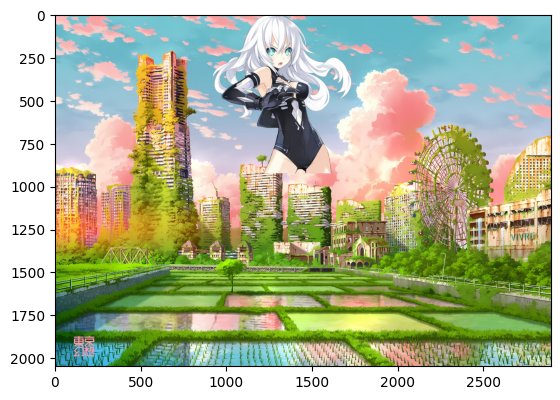

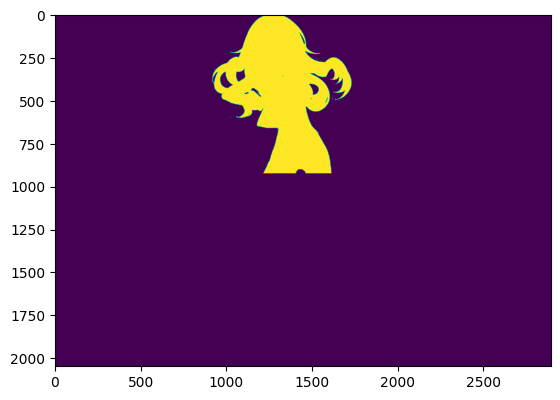

In [3]:
# 打印出来看看
plt.imshow(mixed_pic)
plt.show()
mixed_mask = np.array(mixed_mask)
plt.imshow(mixed_mask)
plt.show()

In [4]:
mask2yolo(mixed_mask,show=True)
# 画出来


(8642,)


'0 0.43849343469246715 0.0 0.43814789219073946 0.00048828125 0.43780234968901177 0.00048828125 0.437456807187284 0.00048828125 0.43711126468555633 0.00048828125 0.4367657221838286 0.00048828125 0.4364201796821009 0.00048828125 0.4360746371803732 0.00048828125 0.43572909467864546 0.00048828125 0.43538355217691777 0.00048828125 0.4350380096751901 0.00048828125 0.4346924671734623 0.00048828125 0.43434692467173464 0.00048828125 0.4340013821700069 0.00048828125 0.4336558396682792 0.00048828125 0.4333102971665515 0.00048828125 0.43296475466482376 0.00048828125 0.43261921216309607 0.00048828125 0.4322736696613684 0.0009765625 0.43192812715964063 0.0009765625 0.43158258465791294 0.0009765625 0.4312370421561852 0.0009765625 0.4308914996544575 0.0009765625 0.4305459571527298 0.0009765625 0.43020041465100206 0.0009765625 0.42985487214927437 0.0009765625 0.4295093296475466 0.00146484375 0.42916378714581893 0.00146484375 0.42881824464409124 0.00146484375 0.4284727021423635 0.00146484375 0.428127159